<a href="https://colab.research.google.com/github/SwatiNeha/neural-networks-applied/blob/main/GaussainUniform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Gaussian to Uniform and Vice Versa**
---



***Defining MMD Loss function***

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#Using MMD Loss:
class RBF(nn.Module):

    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.band_mul = mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        self.bandwidth = bandwidth

    def get_bandwidth(self, L_dist):
        if self.bandwidth is None:
            n_samples = L_dist.shape[0]
            return L_dist.data.sum() / (n_samples ** 2 - n_samples)

        return self.bandwidth

    def forward(self, X):
        L_dist = torch.cdist(X, X) ** 2
        return torch.exp(-L_dist[None, ...] / (self.get_bandwidth(L_dist) * self.band_mul)[:, None, None]).sum(dim=0)


class MMDLoss(nn.Module):

    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))

        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        return XX - 2 * XY + YY

***1. Training a fully connected NN to convert 2D Gaussian to 2D Uniform Data***

f1 - Epoch [100/1000], Loss: 0.6366214752197266
f1 - Epoch [200/1000], Loss: 0.3517885208129883
f1 - Epoch [300/1000], Loss: 0.3430161476135254
f1 - Epoch [400/1000], Loss: 0.3666660785675049
f1 - Epoch [500/1000], Loss: 0.8322463035583496
f1 - Epoch [600/1000], Loss: 1.0625319480895996
f1 - Epoch [700/1000], Loss: 0.5962955951690674
f1 - Epoch [800/1000], Loss: 0.4993934631347656
f1 - Epoch [900/1000], Loss: 0.6067855358123779
f1 - Epoch [1000/1000], Loss: 0.2877655029296875


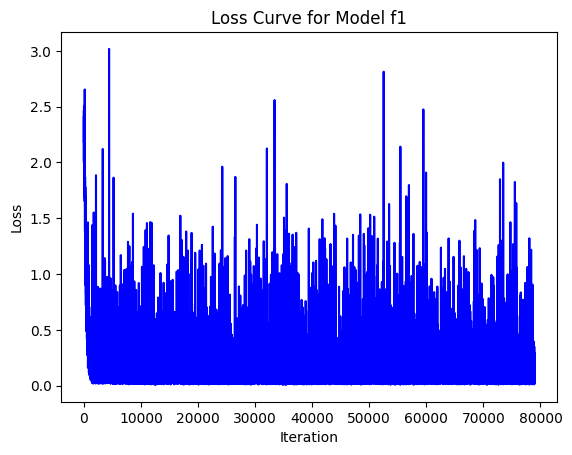

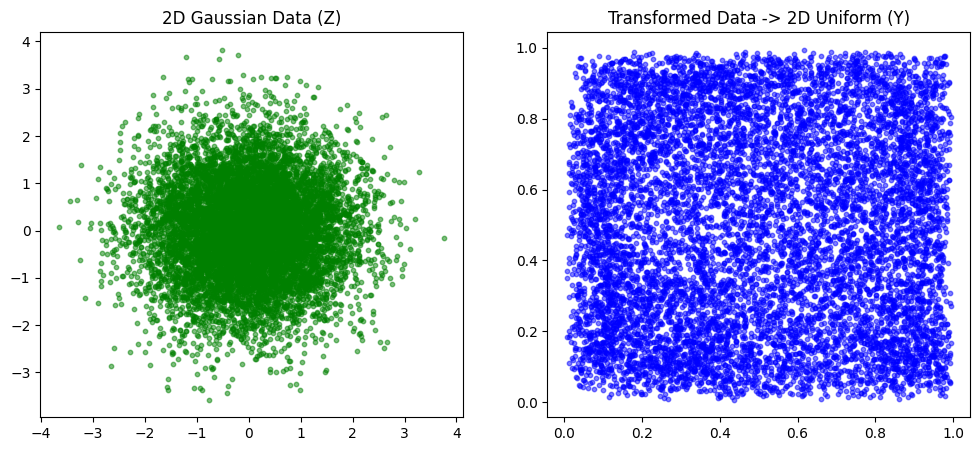

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

class Model_GaustoUni(nn.Module):
    def __init__(self):
        super(Model_GaustoUni, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

def gen_gaus_data(tot_samp):
    return torch.randn(tot_samp, 2)

def gen_uni_gaus(tot_samp):
    return torch.rand(tot_samp, 2)

# Plotting/Visualizing
def plot_data(data1, data2, title1, title2, color1, color2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(data1[:, 0].detach().numpy(), data1[:, 1].detach().numpy(), s=10, alpha=0.5, color=color1)
    ax[0].set_title(title1)

    ax[1].scatter(data2[:, 0].detach().numpy(), data2[:, 1].detach().numpy(), s=10, alpha=0.5, color=color2)
    ax[1].set_title(title2)

    plt.show()

# Parameters
tot_samples = 5000
epochs = 1000
batch_size = 64
ln_rate = 0.001


Z = gen_gaus_data(tot_samples)
Y = gen_uni_gaus(tot_samples)


model_f1 = Model_GaustoUni()
criterion_f1 = MMDLoss()
optimizer_f1 = optim.SGD(model_f1.parameters(), lr=ln_rate)

# Training loop
losses_f1 = []

for epoch in range(epochs):
    permutation = torch.randperm(Z.size()[0])
    for i in range(0, Z.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_Z, batch_Y = Z[indices], Y[indices]

        optimizer_f1.zero_grad()
        outputs = model_f1(batch_Z)
        loss = criterion_f1(outputs, batch_Y)
        loss.backward()
        optimizer_f1.step()

        losses_f1.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'f1 - Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

plt.plot(losses_f1, color='blue')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Model f1')
plt.show()


test_data_f1 = gen_gaus_data(10000)
trans_Y_from_f1 = model_f1(test_data_f1)

plot_data(test_data_f1, trans_Y_from_f1, '2D Gaussian Data (Z)', 'Transformed Data -> 2D Uniform (Y)', 'green', 'blue')

***2. Training a second network to convert 2D Uniform to 2D Gaussian data***

f2 - Epoch [100/5000], Loss: 0.3911616802215576
f2 - Epoch [200/5000], Loss: 0.7383315563201904
f2 - Epoch [300/5000], Loss: 0.30262017250061035
f2 - Epoch [400/5000], Loss: 0.379223108291626
f2 - Epoch [500/5000], Loss: 0.0010328292846679688
f2 - Epoch [600/5000], Loss: 0.0015027523040771484
f2 - Epoch [700/5000], Loss: 0.0005161762237548828
f2 - Epoch [800/5000], Loss: 0.0004024505615234375
f2 - Epoch [900/5000], Loss: 0.003922462463378906
f2 - Epoch [1000/5000], Loss: 0.00016689300537109375
f2 - Epoch [1100/5000], Loss: 0.0028705596923828125
f2 - Epoch [1200/5000], Loss: 0.0006983280181884766
f2 - Epoch [1300/5000], Loss: 0.0003027915954589844
f2 - Epoch [1400/5000], Loss: 0.0003376007080078125
f2 - Epoch [1500/5000], Loss: 0.0005955696105957031
f2 - Epoch [1600/5000], Loss: 0.0008854866027832031
f2 - Epoch [1700/5000], Loss: 0.00035858154296875
f2 - Epoch [1800/5000], Loss: 0.00042748451232910156
f2 - Epoch [1900/5000], Loss: 0.00045800209045410156
f2 - Epoch [2000/5000], Loss: 0.0

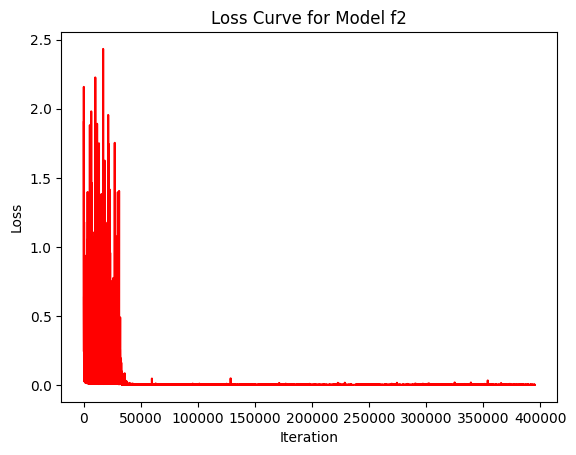

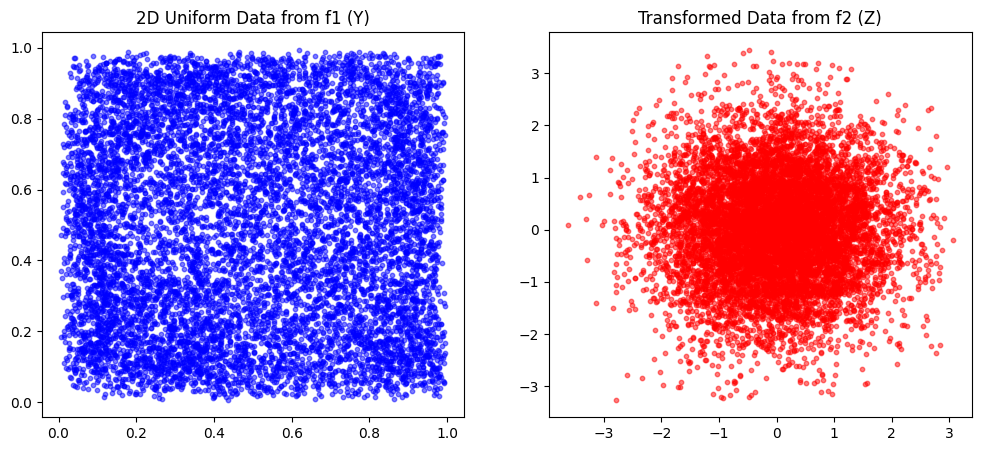

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm


class Model_UnitoGaus(nn.Module):
    def __init__(self):
        super(Model_UnitoGaus, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Plotting
def plot_data(data1, data2, title1, title2, color1, color2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(data1[:, 0].detach().numpy(), data1[:, 1].detach().numpy(), s=10, alpha=0.5, color=color1)
    ax[0].set_title(title1)

    ax[1].scatter(data2[:, 0].detach().numpy(), data2[:, 1].detach().numpy(), s=10, alpha=0.5, color=color2)
    ax[1].set_title(title2)

    plt.show()

def gen_gaus_data(tot_samp):
    return torch.randn(tot_samp, 2)

def gen_uni_gaus(tot_samp):
    return torch.rand(tot_samp, 2)

# Parameters
tot_samples = 5000
epochs = 5000
batch_size = 32
ln_rate = 0.001

Y = gen_uni_data(tot_samples)
Z = gen_gaus_data(tot_samples)

model_f2 = Model_UnitoGaus()
criterion_f2 = MMDLoss()
optimizer_f2 = optim.Adam(model_f2.parameters(), lr=ln_rate)

# Training loop
losses_f2 = []

for epoch in range(epochs):
    permutation = torch.randperm(Y.size()[0])
    for i in range(0, Y.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_Y = Y[indices]
        batch_Z = Z[indices].detach()

        optimizer_f2.zero_grad()
        outputs = model_f2(batch_Y)
        loss = criterion_f2(outputs, batch_Z)
        loss.backward()
        optimizer_f2.step()

        losses_f2.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'f2 - Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')


plt.plot(losses_f2, color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Model f2')
plt.show()

trans_Z_from_f2 = model_f2(trans_Y_from_f1)

plot_data(trans_Y_from_f1, trans_Z_from_f2, '2D Uniform Data from f1 (Y)', 'Transformed Data from f2 (Z)', 'blue', 'red')

***3. Training f1 with different L1 and L2 Regularizations***

Training with L1: 0.0, L2: 0.0
Epoch [100/1000], Loss: 0.7942509651184082
Epoch [200/1000], Loss: 0.46070241928100586
Epoch [300/1000], Loss: 0.2852342128753662
Epoch [400/1000], Loss: 0.40430426597595215
Epoch [500/1000], Loss: 0.30399584770202637
Epoch [600/1000], Loss: 0.6528332233428955
Epoch [700/1000], Loss: 0.6818938255310059
Epoch [800/1000], Loss: 0.15157198905944824
Epoch [900/1000], Loss: 0.572188138961792
Epoch [1000/1000], Loss: 0.43857431411743164


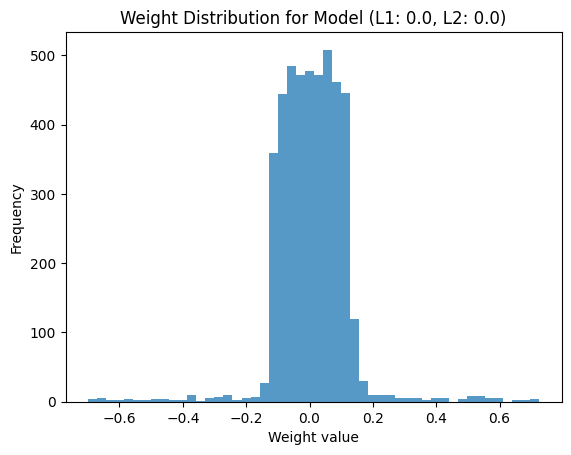

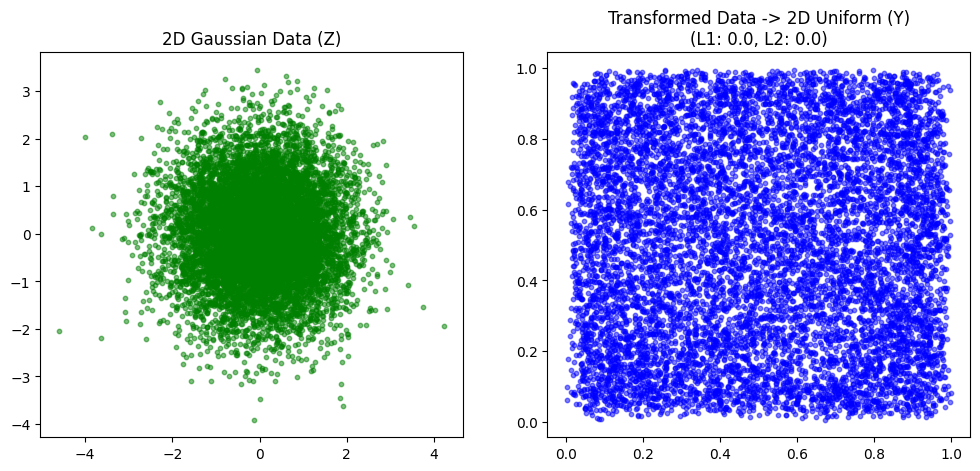

Training with L1: 0.0, L2: 0.001
Epoch [100/1000], Loss: 0.32709401845932007
Epoch [200/1000], Loss: 0.625078558921814
Epoch [300/1000], Loss: 0.3919748067855835
Epoch [400/1000], Loss: 0.2674935758113861
Epoch [500/1000], Loss: 0.6007182002067566
Epoch [600/1000], Loss: 0.2071988880634308
Epoch [700/1000], Loss: 0.3968414068222046
Epoch [800/1000], Loss: 0.14842386543750763
Epoch [900/1000], Loss: 0.25474813580513
Epoch [1000/1000], Loss: 0.34280651807785034


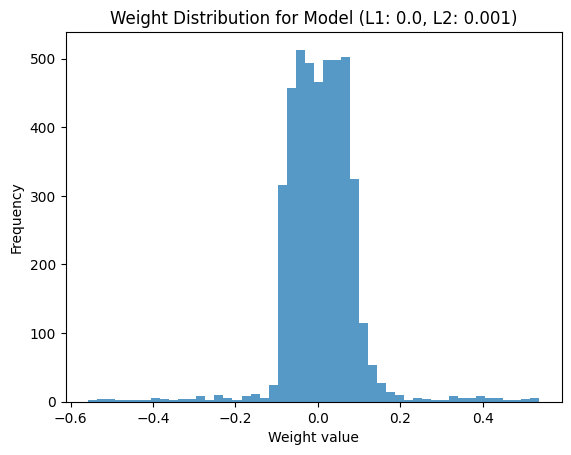

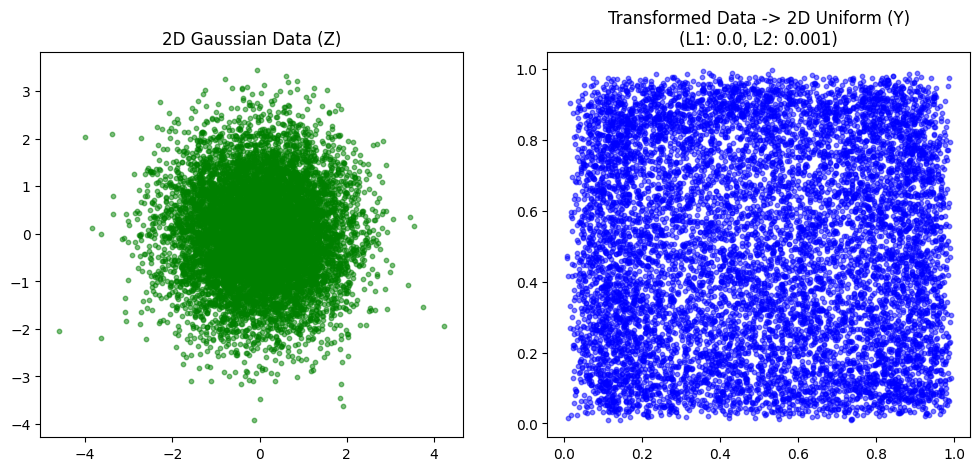

Training with L1: 0.0, L2: 0.01
Epoch [100/1000], Loss: 0.7401918172836304
Epoch [200/1000], Loss: 0.7745168805122375
Epoch [300/1000], Loss: 0.33988410234451294
Epoch [400/1000], Loss: 0.2939334809780121
Epoch [500/1000], Loss: 0.6531635522842407
Epoch [600/1000], Loss: 0.9472773671150208
Epoch [700/1000], Loss: 0.3523108959197998
Epoch [800/1000], Loss: 0.2833123803138733
Epoch [900/1000], Loss: 0.3471169173717499
Epoch [1000/1000], Loss: 0.33429014682769775


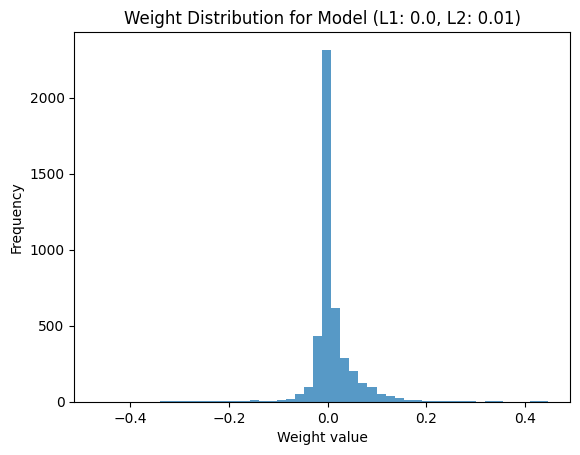

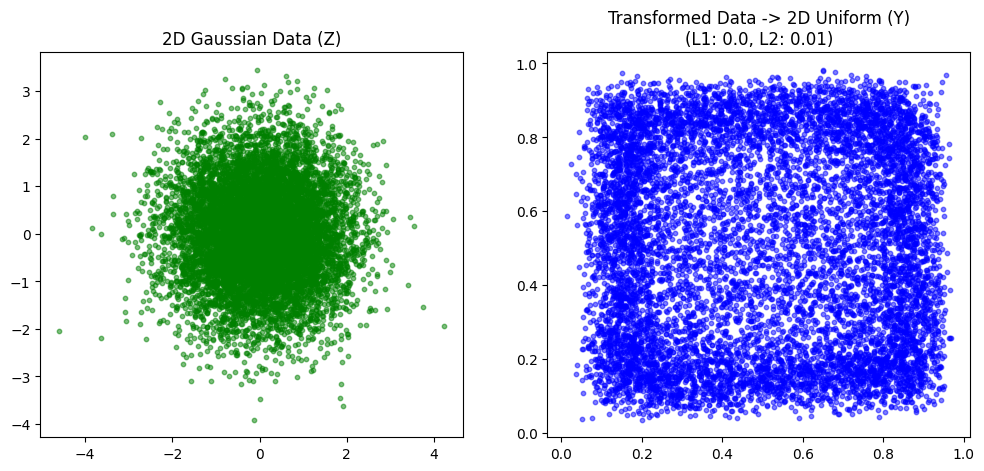

Training with L1: 0.001, L2: 0.0
Epoch [100/1000], Loss: 0.4976727366447449
Epoch [200/1000], Loss: 0.5856300592422485
Epoch [300/1000], Loss: 0.5165340304374695
Epoch [400/1000], Loss: 0.44190919399261475
Epoch [500/1000], Loss: 0.6357356309890747
Epoch [600/1000], Loss: 0.687863826751709
Epoch [700/1000], Loss: 0.3267326354980469
Epoch [800/1000], Loss: 0.6062127947807312
Epoch [900/1000], Loss: 0.820330798625946
Epoch [1000/1000], Loss: 0.8324720859527588


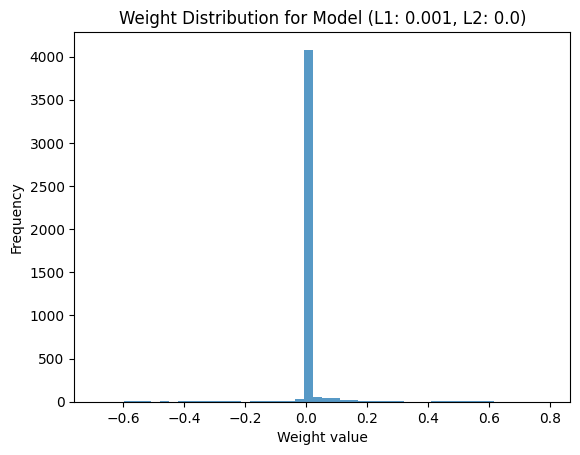

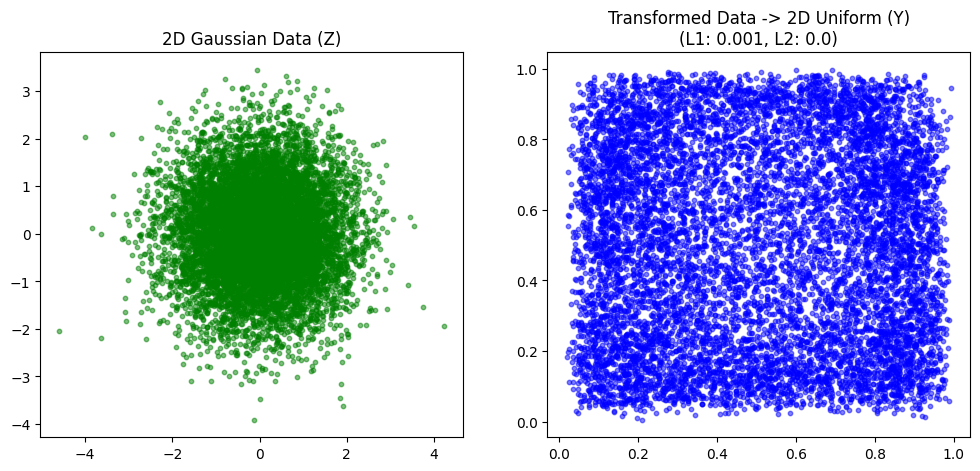

Training with L1: 0.001, L2: 0.001
Epoch [100/1000], Loss: 0.6334145069122314
Epoch [200/1000], Loss: 0.35994911193847656
Epoch [300/1000], Loss: 0.42310333251953125
Epoch [400/1000], Loss: 0.8944500684738159
Epoch [500/1000], Loss: 0.2656121551990509
Epoch [600/1000], Loss: 0.31670787930488586
Epoch [700/1000], Loss: 0.6223586797714233
Epoch [800/1000], Loss: 0.5536832809448242
Epoch [900/1000], Loss: 0.592168390750885
Epoch [1000/1000], Loss: 0.7029625773429871


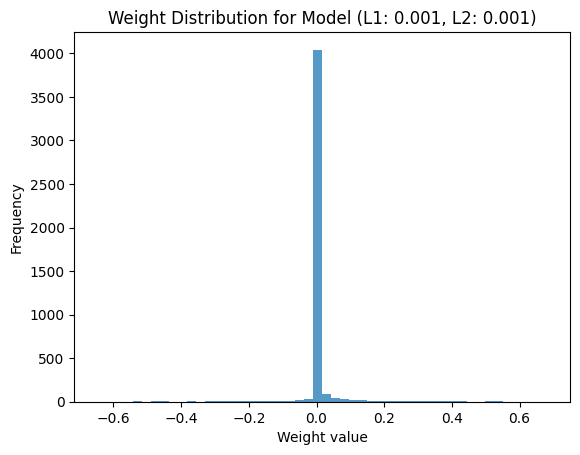

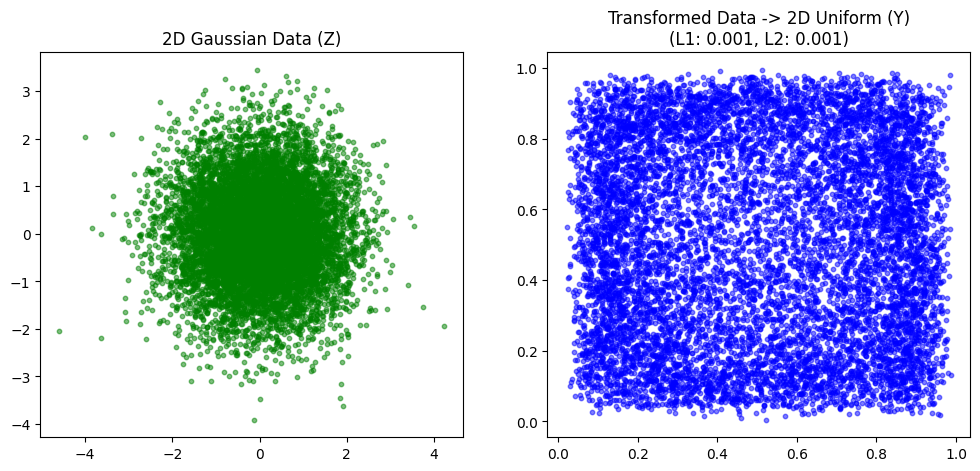

Training with L1: 0.001, L2: 0.01
Epoch [100/1000], Loss: 0.8193656206130981
Epoch [200/1000], Loss: 0.5572261214256287
Epoch [300/1000], Loss: 0.4402560591697693
Epoch [400/1000], Loss: 0.8759320378303528
Epoch [500/1000], Loss: 0.8916651010513306
Epoch [600/1000], Loss: 0.5017861127853394
Epoch [700/1000], Loss: 0.6641826033592224
Epoch [800/1000], Loss: 0.48395583033561707
Epoch [900/1000], Loss: 0.2989686131477356
Epoch [1000/1000], Loss: 0.5550951957702637


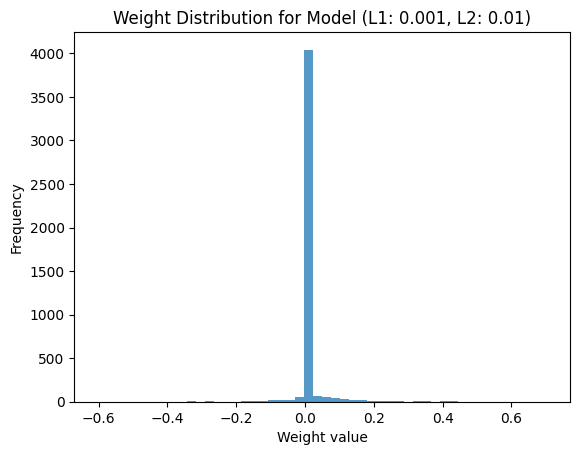

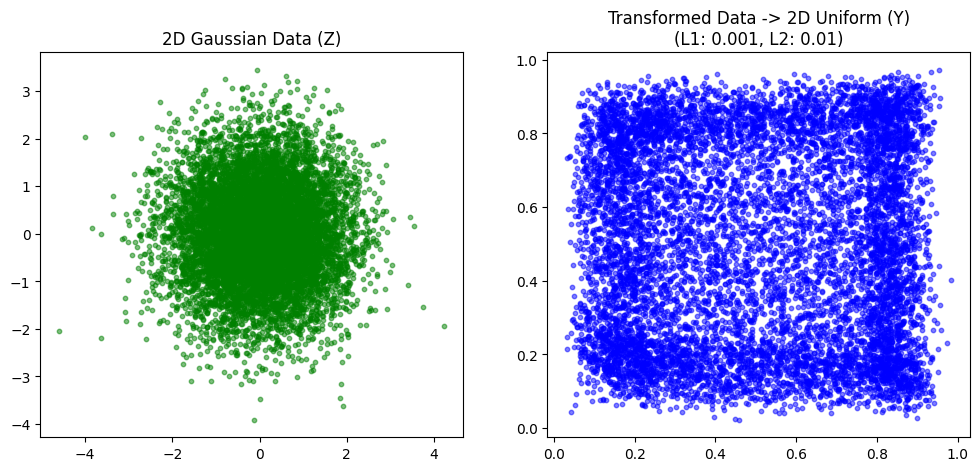

Training with L1: 0.01, L2: 0.0
Epoch [100/1000], Loss: 1.4641051292419434
Epoch [200/1000], Loss: 0.6906046867370605
Epoch [300/1000], Loss: 0.4908239245414734
Epoch [400/1000], Loss: 1.229365587234497
Epoch [500/1000], Loss: 0.5851044058799744
Epoch [600/1000], Loss: 0.34319448471069336
Epoch [700/1000], Loss: 0.45432746410369873
Epoch [800/1000], Loss: 0.9730764627456665
Epoch [900/1000], Loss: 0.4276115298271179
Epoch [1000/1000], Loss: 0.6695391535758972


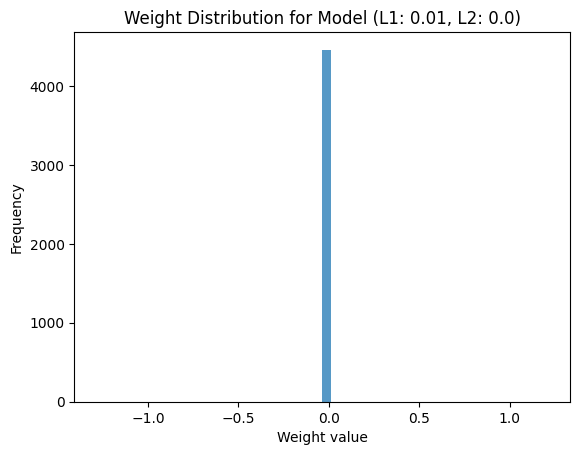

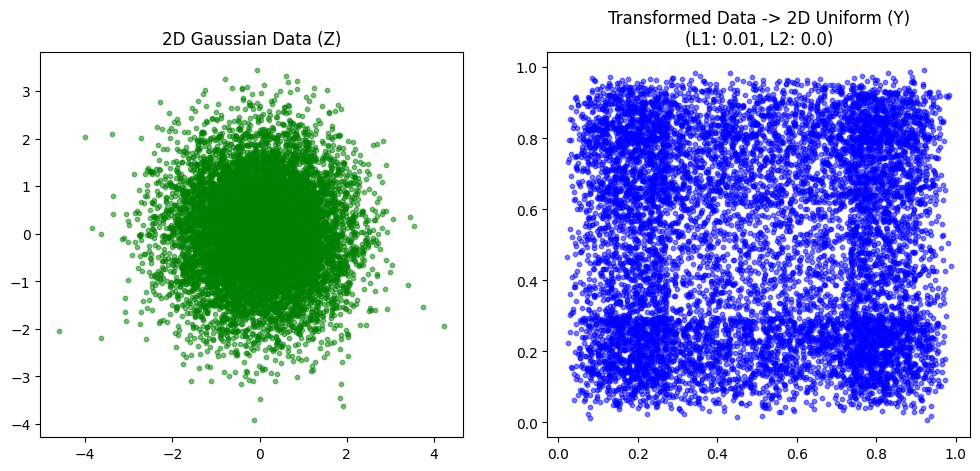

Training with L1: 0.01, L2: 0.001
Epoch [100/1000], Loss: 1.0229560136795044
Epoch [200/1000], Loss: 0.7043942809104919
Epoch [300/1000], Loss: 1.130355954170227
Epoch [400/1000], Loss: 0.6163074970245361
Epoch [500/1000], Loss: 0.5770258903503418
Epoch [600/1000], Loss: 0.6210188865661621
Epoch [700/1000], Loss: 0.5164906978607178
Epoch [800/1000], Loss: 0.4355482757091522
Epoch [900/1000], Loss: 0.22368307411670685
Epoch [1000/1000], Loss: 0.689982533454895


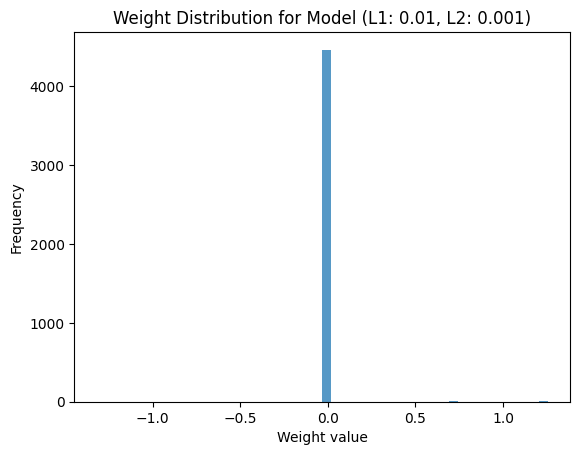

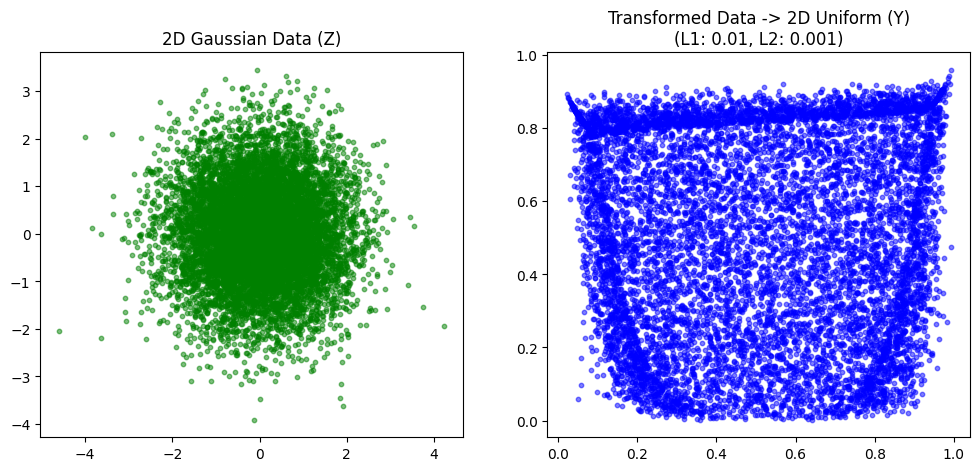

Training with L1: 0.01, L2: 0.01
Epoch [100/1000], Loss: 1.2745803594589233
Epoch [200/1000], Loss: 0.7366732358932495
Epoch [300/1000], Loss: 0.9409107565879822
Epoch [400/1000], Loss: 0.9831054210662842
Epoch [500/1000], Loss: 0.5554744601249695
Epoch [600/1000], Loss: 0.9489085078239441
Epoch [700/1000], Loss: 0.5300641655921936
Epoch [800/1000], Loss: 0.4117991030216217
Epoch [900/1000], Loss: 0.49333834648132324
Epoch [1000/1000], Loss: 0.7420609593391418


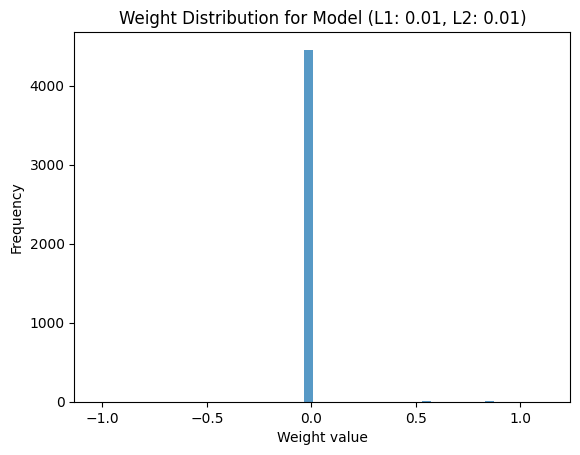

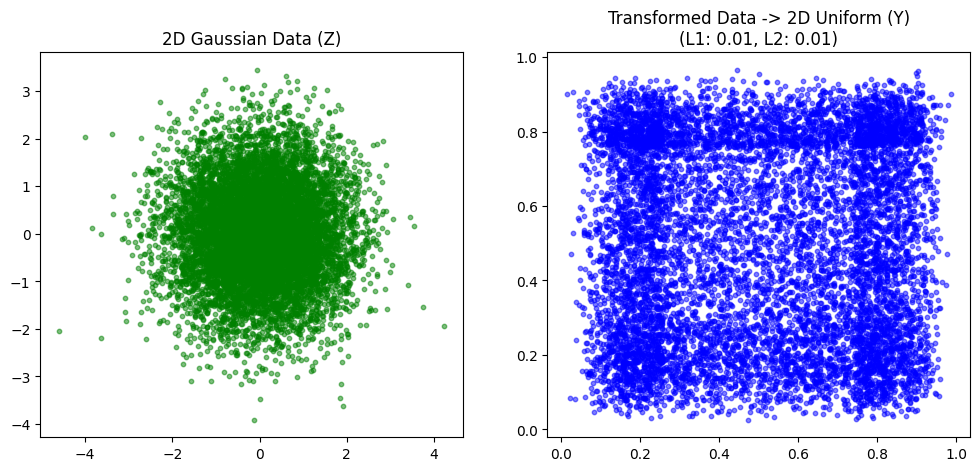

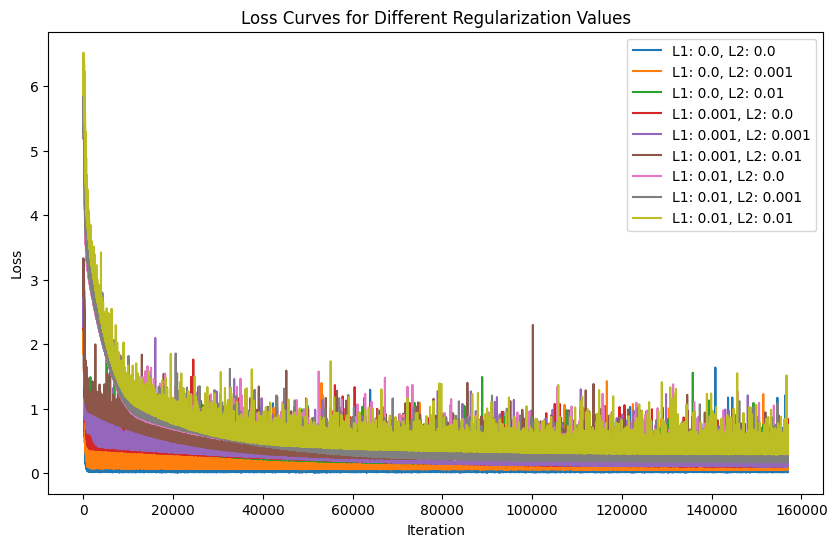

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Defining L1 and L2 regularization functions
def l1_penalty(model, lambda_l1):
    l1_loss = 0
    for param in model.parameters():
        l1_loss += torch.sum(torch.abs(param))
    return lambda_l1 * l1_loss

def l2_penalty(model, lambda_l2):
    l2_loss = 0
    for param in model.parameters():
        l2_loss += torch.sum(param ** 2)
    return lambda_l2 * l2_loss


class Model_GaustoUni(nn.Module):
    def __init__(self):
        super(Model_GaustoUni, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

class RBF(nn.Module):
    def __init__(self, n_kernels=5, mul_factor=2.0, bandwidth=None):
        super().__init__()
        self.band_mul = mul_factor ** (torch.arange(n_kernels) - n_kernels // 2)
        self.bandwidth = bandwidth

    def get_bandwidth(self, L_dist):
        if self.bandwidth is None:
            n_samples = L_dist.shape[0]
            return L_dist.data.sum() / (n_samples ** 2 - n_samples)
        return self.bandwidth

    def forward(self, X):
        L_dist = torch.cdist(X, X) ** 2
        return torch.exp(-L_dist[None, ...] / (self.get_bandwidth(L_dist) * self.band_mul)[:, None, None]).sum(dim=0)

class MMDLoss(nn.Module):
    def __init__(self, kernel=RBF()):
        super().__init__()
        self.kernel = kernel

    def forward(self, X, Y):
        K = self.kernel(torch.vstack([X, Y]))
        X_size = X.shape[0]
        XX = K[:X_size, :X_size].mean()
        XY = K[:X_size, X_size:].mean()
        YY = K[X_size:, X_size:].mean()
        return XX - 2 * XY + YY

def gen_gaus_data(tot_samp):
    return torch.randn(tot_samp, 2)

def gen_uni_data(tot_samp):
    return torch.rand(tot_samp, 2)

# Training function with regularization
def train_model_with_regularization(model, Z, Y, lambda_l1, lambda_l2, epochs=1000, batch_size=64, learning_rate=0.001):
    criterion = MMDLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    losses = []

    for epoch in range(epochs):
        permutation = torch.randperm(Z.size()[0])
        for i in range(0, Z.size()[0], batch_size):
            indices = permutation[i:i + batch_size]
            batch_Z, batch_Y = Z[indices], Y[indices]

            optimizer.zero_grad()
            outputs = model(batch_Z)
            loss = criterion(outputs, batch_Y)

            # Add L1 and L2 regularization penalties
            if lambda_l1 > 0:
                loss += l1_penalty(model, lambda_l1)
            if lambda_l2 > 0:
                loss += l2_penalty(model, lambda_l2)

            loss.backward()
            optimizer.step()

            losses.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')

    return losses

def plot_data(data1, data2, title1, title2, color1, color2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    ax[0].scatter(data1[:, 0].detach().numpy(), data1[:, 1].detach().numpy(), s=10, alpha=0.5, color=color1)
    ax[0].set_title(title1)
    ax[1].scatter(data2[:, 0].detach().numpy(), data2[:, 1].detach().numpy(), s=10, alpha=0.5, color=color2)
    ax[1].set_title(title2)
    plt.show()

def plot_weight_distribution(model, title):
    weights = []
    for param in model.parameters():
        weights.extend(param.detach().numpy().flatten())
    plt.hist(weights, bins=50, alpha=0.75)
    plt.title(title)
    plt.xlabel('Weight value')
    plt.ylabel('Frequency')
    plt.show()

# Parameters and Data
tot_samples = 10000
epochs = 1000
batch_size = 64
learning_rate = 0.001

Z = gen_gaus_data(tot_samples)
Y = gen_uni_data(tot_samples)

# Regularization values
l1_lambda_values = [0.0, 0.001, 0.01]
l2_lambda_values = [0.0, 0.001, 0.01]

# Initialize a dictionary to store losses for different regularization values
all_losses = {}

for l1_lambda in l1_lambda_values:
    for l2_lambda in l2_lambda_values:
        model = Model_GaustoUni()
        print(f'Training with L1: {l1_lambda}, L2: {l2_lambda}')
        losses = train_model_with_regularization(model, Z, Y, l1_lambda, l2_lambda)
        transformed_Y = model(Z)
        all_losses[(l1_lambda, l2_lambda)] = (losses, transformed_Y, model)

        # Plotting weight distributions
        plot_weight_distribution(model, f'Weight Distribution for Model (L1: {l1_lambda}, L2: {l2_lambda})')


        plot_data(Z, transformed_Y, '2D Gaussian Data (Z)', f'Transformed Data -> 2D Uniform (Y)\n(L1: {l1_lambda}, L2: {l2_lambda})', 'green', 'blue')

# Plotting all loss curves in one plot
plt.figure(figsize=(10, 6))
for (l1_lambda, l2_lambda), (losses, _, _) in all_losses.items():
    plt.plot(losses, label=f'L1: {l1_lambda}, L2: {l2_lambda}')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curves for Different Regularization Values')
plt.legend()
plt.show()

***4. Training third network to convert 1D Uniform to 2D Gaussian Data***

f3 - Epoch [100/5000], Loss: 1.3558990955352783
f3 - Epoch [200/5000], Loss: 0.37752580642700195
f3 - Epoch [300/5000], Loss: 0.8180932998657227
f3 - Epoch [400/5000], Loss: 0.1674206256866455
f3 - Epoch [500/5000], Loss: 0.5464034080505371
f3 - Epoch [600/5000], Loss: 0.43207788467407227
f3 - Epoch [700/5000], Loss: 0.8684349060058594
f3 - Epoch [800/5000], Loss: 0.9805769920349121
f3 - Epoch [900/5000], Loss: 0.30771756172180176
f3 - Epoch [1000/5000], Loss: 0.3229391574859619
f3 - Epoch [1100/5000], Loss: 0.35916566848754883
f3 - Epoch [1200/5000], Loss: 0.4501008987426758
f3 - Epoch [1300/5000], Loss: 0.40808844566345215
f3 - Epoch [1400/5000], Loss: 0.475963830947876
f3 - Epoch [1500/5000], Loss: 0.8396918773651123
f3 - Epoch [1600/5000], Loss: 1.2051527500152588
f3 - Epoch [1700/5000], Loss: 0.7209835052490234
f3 - Epoch [1800/5000], Loss: 0.32540440559387207
f3 - Epoch [1900/5000], Loss: 0.42705273628234863
f3 - Epoch [2000/5000], Loss: 0.7429525852203369
f3 - Epoch [2100/5000],

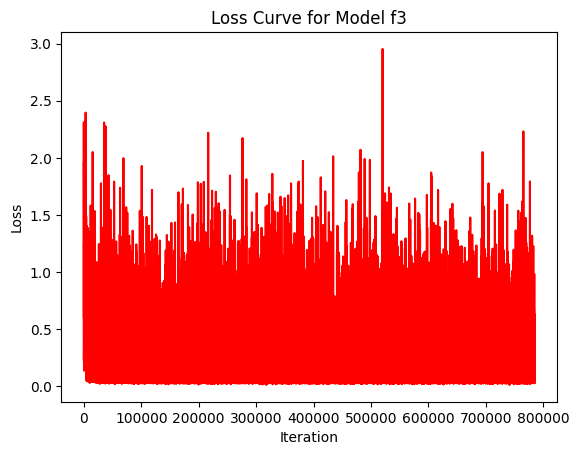

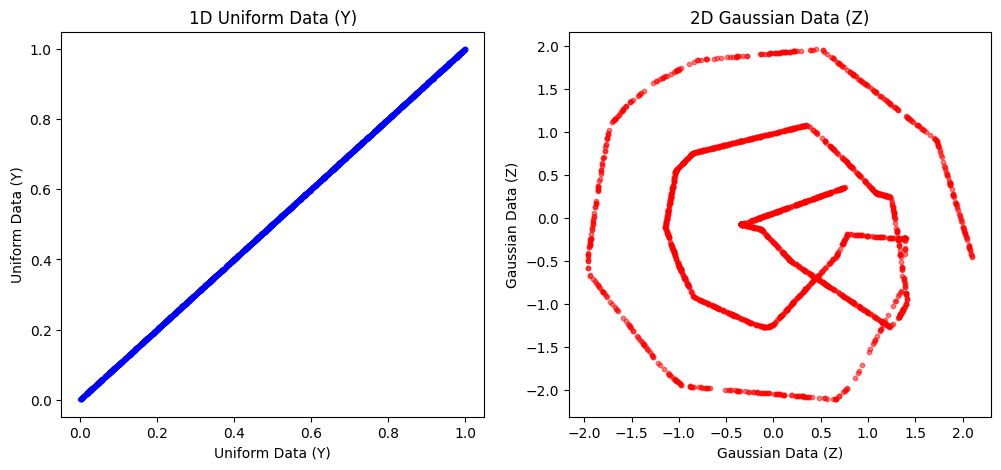

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Set random seeds for reproducibility
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)


class Model_1DTo2D(nn.Module):
    def __init__(self):
        super(Model_1DTo2D, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def gen_gaus_data(tot_samp):
    return torch.randn(tot_samp, 2)


def gen_uni_data_1d(tot_samp):
    return torch.rand(tot_samp, 1)

def plot_data_1d_to_2d(data1, data2, title1, title2, color1, color2):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].scatter(data1[:, 0].detach().numpy(), data1[:, 0].detach().numpy(), s=10, alpha=0.5, color=color1)
    ax[0].set_title(title1)
    ax[0].set_xlabel('Uniform Data (Y)')
    ax[0].set_ylabel('Uniform Data (Y)')

    ax[1].scatter(data2[:, 0].detach().numpy(), data2[:, 1].detach().numpy(), s=10, alpha=0.5, color=color2)
    ax[1].set_title(title2)
    ax[1].set_xlabel('Gaussian Data (Z)')
    ax[1].set_ylabel('Gaussian Data (Z)')

    plt.show()


# Parameters
tot_samples = 5000
epochs = 5000
batch_size = 32
ln_rate = 0.001

# Generate 1D uniform data and corresponding 2D Gaussian data
Y1 = gen_uni_data_1d(tot_samples)
Z1 = gen_gaus_data(tot_samples)

model_f3 = Model_1DTo2D()
criterion_f3 = MMDLoss()  # Using the defined MMD loss function
optimizer_f3 = optim.Adam(model_f3.parameters(), lr=ln_rate)

# Training loop
losses_f3 = []

for epoch in range(epochs):
    permutation = torch.randperm(Y1.size()[0])
    for i in range(0, Y1.size()[0], batch_size):
        indices = permutation[i:i + batch_size]
        batch_Y = Y1[indices]
        batch_Z = Z1[indices].detach()

        optimizer_f3.zero_grad()
        outputs = model_f3(batch_Y)
        loss = criterion_f3(outputs, batch_Z)
        loss.backward()
        optimizer_f3.step()

        losses_f3.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'f3 - Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}')


plt.plot(losses_f3, color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve for Model f3')
plt.show()

# Generate new 1D uniform data and transform using the trained model
M1 = gen_uni_data_1d(2000)
trans_Z_from_f3 = model_f3(M1)

# Plot the original and transformed data
plot_data_1d_to_2d(M1, trans_Z_from_f3, '1D Uniform Data (Y)', '2D Gaussian Data (Z)', 'blue', 'red')

***Other methods tried for generating 1D unifor to 2D gaussian***

Epoch 100, Loss: 0.01694464683532715
Epoch 200, Loss: 0.008255243301391602
Epoch 300, Loss: 0.006251811981201172
Epoch 400, Loss: 0.0028984546661376953
Epoch 500, Loss: 0.0029435157775878906
Epoch 600, Loss: 0.00616765022277832
Epoch 700, Loss: 0.004105091094970703
Epoch 800, Loss: 0.0050547122955322266
Epoch 900, Loss: 0.0021059513092041016
Epoch 1000, Loss: 0.0033156871795654297


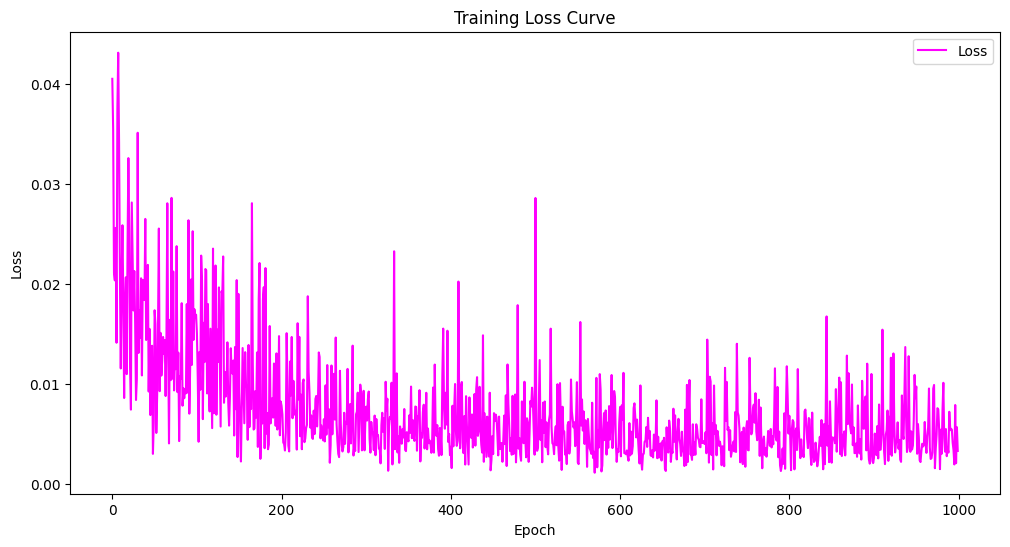

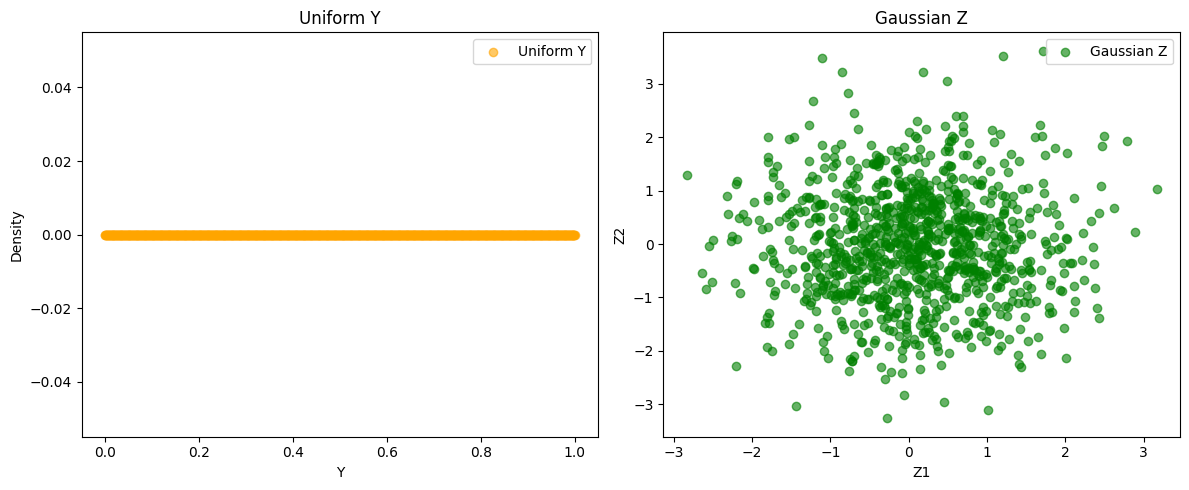

In [ ]:
#Variational AutoEncoders

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


seed = 40
np.random.seed(seed)
torch.manual_seed(seed)

class Uni1D_to_2DGaus(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Uni1D_to_2DGaus, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3_mean = nn.Linear(hidden_dim2, output_dim)
        self.fc3_logvar = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mean = self.fc3_mean(x)
        logvar = self.fc3_logvar(x)
        return mean, logvar

model_f3 = Uni1D_to_2DGaus(input_dim=1, hidden_dim1=128, hidden_dim2=64, output_dim=2)

criterion = MMDLoss()
optimizer = torch.optim.SGD(model_f3.parameters(), lr=0.001)

loss_history = []


for epoch in range(1000):
    y = np.random.uniform(-1, 1, size=(1000, 1))  # Using range 0, 1
    y = torch.tensor(y, dtype=torch.float32)

    # Mapping to Gaussian
    mean, logvar = model_f3(y)

    # Computing loss
    z = mean + torch.exp(0.5 * logvar) * torch.randn_like(mean)
    loss = criterion(z, torch.randn_like(z))



    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())


    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

plt.figure(figsize=(12, 6))
plt.plot(loss_history, color='magenta', label='Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


y_rng = np.linspace(0, 1, 1000)
y_rng = torch.tensor(y_rng, dtype=torch.float32).unsqueeze(1)
mean, logvar = model_f3(y_rng)
z_rng = mean.detach().numpy() + np.exp(0.5 * logvar.detach().numpy()) * np.random.randn(*mean.shape)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.scatter(y_rng[:, 0], np.zeros_like(y_rng[:, 0]), alpha=0.6, color='orange', label='Uniform Y')
plt.title('Uniform Y')
plt.xlabel('Y')
plt.ylabel('Density')
plt.legend()


plt.subplot(1, 2, 2)
plt.scatter(z_rng[:, 0], z_rng[:, 1], alpha=0.6, color='green', label='Gaussian Z')
plt.title('Gaussian Z')
plt.xlabel('Z1')
plt.ylabel('Z2')
plt.legend()


plt.tight_layout()
plt.show()

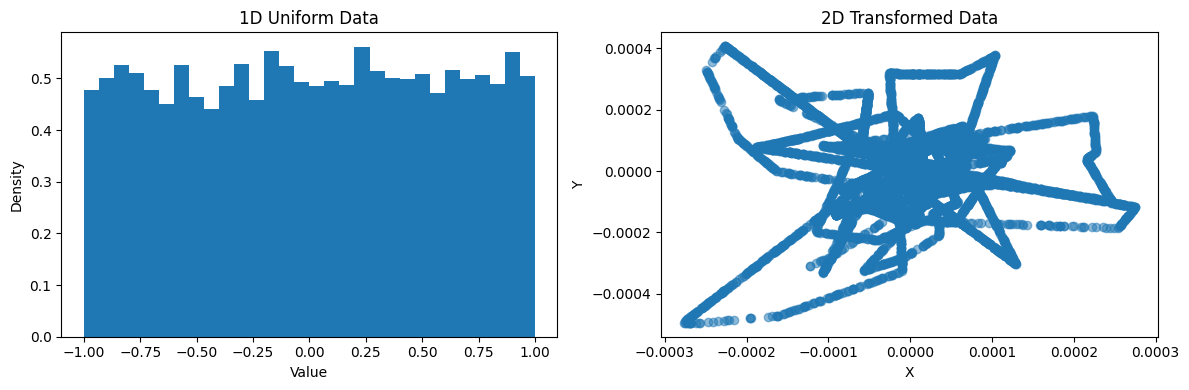

In [ ]:
import torch
import torch.nn as nn
#from torch.nn import functional as F  # For KL divergence

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
seed = 40
np.random.seed(seed)
torch.manual_seed(seed)

class UniTo2D(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(UniTo2D, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Generate uniform data
num_samples = 10000
uniform_data = np.random.uniform(-1, 1, size=num_samples)
uniform_data_tensor = torch.tensor(uniform_data, dtype=torch.float32).view(-1, 1)

# Create the model
model = UniTo2D(input_size=1, hidden_size=64, output_size=2)

# KL divergence loss function (replace MSE)
def kl_divergence(mu, logvar):
    # Assuming standard normal distribution with mu=0 and var=1
    std = torch.exp(0.5 * logvar)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - std.pow(2))

# Define optimizer (adjust learning rate if needed)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(uniform_data_tensor)
    target = torch.zeros_like(outputs)  # Assuming zero mean Gaussian

    # Calculate KL divergence (mu and logvar from outputs)
    mu, logvar = torch.split(outputs, 1, dim=1)  # Assuming mu and logvar in first and second columns
    loss = kl_divergence(mu, logvar)

    loss.backward()
    optimizer.step()

# Generate transformed data
with torch.no_grad():
    transformed_data = model(uniform_data_tensor).numpy()

# Generate transformed data
with torch.no_grad():
    transformed_data = model(uniform_data_tensor).numpy()

# Plot the original data
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(uniform_data, bins=30, density=True)
plt.title("1D Uniform Data")
plt.xlabel("Value")
plt.ylabel("Density")

# Plot the transformed data
plt.subplot(1, 2, 2)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], alpha=0.5)
plt.title("2D Transformed Data")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()
plt.show()
